# Computing gradients and linear regression in PyTorch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Example 1 -- Computing gradients
In PyTorch keeps track of all operations to be able to compute gradients. Consider the function
$$
\Gamma(\theta_1,\theta_2,\theta_3,\theta_4) = \theta_1 \theta_2+ \theta_3 \theta_4
$$

In [2]:
theta1 = torch.tensor(2, requires_grad=True, dtype=torch.float32)
theta2 = torch.tensor(3, requires_grad=True, dtype=torch.float32)
theta3 = torch.tensor(1, requires_grad=True, dtype=torch.float32)
theta4 = torch.tensor(4, requires_grad=True, dtype=torch.float32)

# Forward propagation
z1 = theta1 * theta2
z2 = theta3 * theta4
f = z1 + z2
f.backward() # Compute gradients

print(f"Gamma's derivative w.r.t. theta_1 is {theta1.grad}")


Gamma's derivative w.r.t. theta_1 is 3.0


$$
\frac{\partial \Gamma}{\partial \theta_1} (\theta_1,\theta_2,\theta_3,\theta_4) = \theta_2 
$$
Let $p = (2,3,1,4)$
$$
\frac{\partial \Gamma}{\partial \theta_1} (2,3,1,4) = 3
$$

## Disable gradient computations with `no_grad()`
Disabling gradient calculation is useful for inference, when you are sure that you will not call `Tensor.backward()`. It will reduce memory consumption for computations that would otherwise have `requires_grad=True`.


In [3]:
x = torch.tensor([1.0], requires_grad=True) # Crucial use floats for this
with torch.no_grad():
    y = x * 2
print(y.requires_grad)
print(x.requires_grad)

# To detach x from the computational graph, use the `.detach()` funciton
x = x.detach()
print(x.requires_grad)



False
True
False


## Example 2 -- Training a one-dimensional linear regression model - Manual version
### Generate data
We generate data based on the very simple model 
$$ y = wx + b + \epsilon, \quad\quad x\sim \mathcal{N}(0,2^2)\text{ and }\epsilon \sim \mathcal{N}(0,0.6^2)$$
where $w=-1.5$ and $b=8.5$.

In [4]:
N = 100      # number of training data
w_ref = -1.5 # We want to learn this parameter
b_ref = 8.5  # We want to learn this parameter

x = 2*torch.randn(N, dtype=torch.float)
noise = 0.6*torch.randn(N, dtype=torch.float)
y = w_ref*x + b_ref + noise

# We are given data y and x

### Create loss function ($l^2$-loss function)
We use the mean squared error loss function. That is 
$$\frac{1}{n} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)})^2. $$

In [5]:
def MSE_loss(prediction, target): # Mean squared error (MSE)
    return (prediction-target).pow(2).mean()

### Use gradient descent to find values for $w$ and $b$ using the data $x$ and $y$
We choose the model $f_{w,b}(x) = wx +b$, and let $\theta = (w,b)$
$$
\Gamma(\theta) = \frac{1}{N}\sum_{k=1}^{N} (wx^{(k)}+b - y^{(k)})^2
$$

Recall the gradient descent step
$$\theta^{(i+1)} = \theta^{(i)} - \eta_i \nabla \Gamma(\theta^{(i)}),$$
where $\eta_i > 0$ is the learning rate (also called step length).


In [6]:
w = torch.tensor(0, dtype=torch.float, requires_grad=True)
b = torch.tensor(0, dtype=torch.float, requires_grad=True)

number_of_epochs = 1000
learning_rate = 0.01 # eta
for iter in range(number_of_epochs):
    y_pred = w*x+b
    loss = MSE_loss(y_pred,y)
    loss.backward() # Compute gradients
    # Update weights, without tracking the computations
    with torch.no_grad():
        w = w - learning_rate*w.grad
        b = b - learning_rate*b.grad
    # In the update step above, these have been set to False
    w.requires_grad = True
    b.requires_grad = True
    
print(w)
print(b)
y_pred = w*x+b
print(MSE_loss(y_pred,y))

tensor(-1.4729, requires_grad=True)
tensor(8.4579, requires_grad=True)
tensor(0.3035, grad_fn=<MeanBackward0>)


### Plot the solution

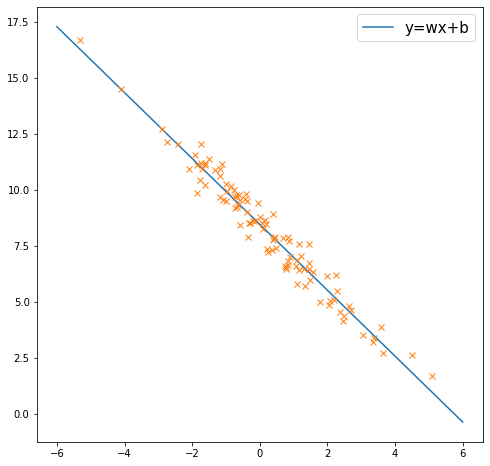

In [7]:
x_equi = torch.linspace(-6,6,101)
y_pred = w*x_equi + b

plt.figure(figsize=(8,8))
plt.plot(x_equi.detach().numpy(), y_pred.detach().numpy(), label='y=wx+b')
plt.plot(x,y, 'x')
plt.legend(fontsize=15)
plt.show()


## Example 3 -- Training a one-dimensional linear regression model - Automatic version
### Create data loader object

In [8]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

train_ds = TensorDataset(x, y)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [9]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

# Build model
input_size = 1
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size, output_size),
)

# Create loss function
loss_fn = nn.MSELoss()

# Choose optimization rule
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)




### Train model

In [10]:


for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch) 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 6.7627
Epoch 10  Loss 1.9409
Epoch 20  Loss 0.1716
Epoch 30  Loss 0.7554
Epoch 40  Loss 0.0330
Epoch 50  Loss 0.0018
Epoch 60  Loss 0.5806
Epoch 70  Loss 0.2473
Epoch 80  Loss 0.1314
Epoch 90  Loss 0.2152
Epoch 100  Loss 0.0052
Epoch 110  Loss 0.3556
Epoch 120  Loss 0.6168
Epoch 130  Loss 0.0090
Epoch 140  Loss 0.2544
Epoch 150  Loss 0.1728
Epoch 160  Loss 0.0273
Epoch 170  Loss 0.2078
Epoch 180  Loss 0.0099
Epoch 190  Loss 0.4521


0.weight Parameter containing:
tensor([[-1.4730]], requires_grad=True)
0.bias Parameter containing:
tensor([8.4587], requires_grad=True)


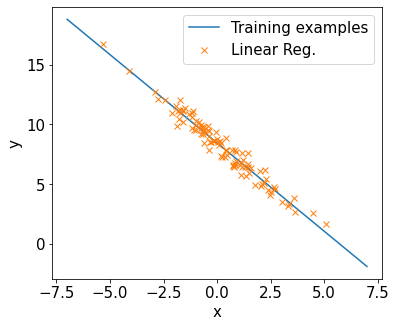

In [11]:
# Print model parameters
for name, param in model.named_parameters():
    print(name, param)

X_test = torch.linspace(-7, 7, steps=100, dtype=torch.float32).reshape(-1, 1)

y_pred = model(X_test).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_test.detach().numpy(), y_pred,)
plt.plot(x, y, 'x')
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [12]:
for name, param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[-1.4730]], requires_grad=True)
0.bias Parameter containing:
tensor([8.4587], requires_grad=True)
